In [100]:
# section 1 load all the necessary modules and packages
import glob
import time
import geopandas as gpd
import netCDF4 as nc4
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import Polygon
# not neccessary for the function but for visualziation
import matplotlib.pyplot as plt
import warnings
import sys
import os
import platform
import shutil
import networkx as nx
import contextily as ctx
import matplotlib  as mpl
font = {'family' : 'Times New Roman',
            'weight' : 'bold',
            'size'   : 40}
mpl.rc('font', **font)


In [101]:
#mm/month
#Month     Jan. Feb. Mar. Apr. May June July Aug. Sept. Oct. Nov. Dec. Total
#Radiation 135  127  144  132  123 109  113  126  135   145  132  129  1550
#Penman    150  145  162  146  138 130  135  144  148   154  145  146  1743

#other studies from Yin
other_evap = np.array([1550, 1350, 1130, 1520, 1450, 1500, 1370, 1590, 1470, 1470, 1590, 1590, 1400])

           Evaporation
Date                  
1969-01-15         135
1969-02-15         127
1969-03-15         144
1969-04-15         132
1969-05-15         123
...                ...
2023-08-15         126
2023-09-15         135
2023-10-15         145
2023-11-15         132
2023-12-15         129

[660 rows x 1 columns]


,Evaporation
Date,
1969-01-15,4.500000
1969-01-16,4.491398
1969-01-17,4.482796
1969-01-18,4.474194
1969-01-19,4.465591
...,...
2023-12-11,4.313333
2023-12-12,4.310000
2023-12-13,4.306667


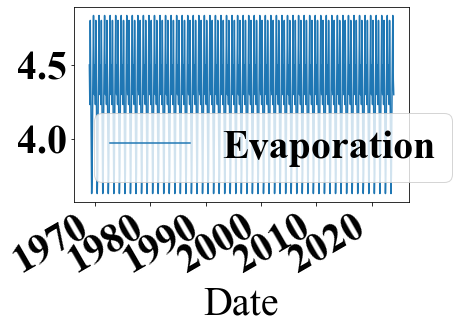

In [102]:
# Define the monthly values
monthly_values = np.array([135, 127, 144, 132, 123, 109, 113, 126, 135, 145, 132, 129])

# Define the range of years
start_year = 1969
end_year = 2023

# Create an empty DataFrame
df = pd.DataFrame(columns=['Date', 'Evaporation'])

# Loop through the years
for year in range(start_year, end_year + 1):
    # Loop through the months
    for month in range(1, 13):
        # Create a date string for the 15th of each month
        date_str = f'{year}-{month:02d}-15'

        # Create a new row with the date and the corresponding monthly value
        row = {'Date': pd.to_datetime(date_str), 'Evaporation': monthly_values[month - 1]}

        # Append the row to the DataFrame
        df = df.append(row, ignore_index=True)

# Print the resulting DataFrame
df['Date'] = pd.to_datetime(df['Date'])
# Set the 'Date' column as the time index
df.set_index('Date', inplace=True)
print(df)

# make it dayly values
df['Evaporation'] = df['Evaporation'].astype(float)/30 # mm per month to mm per day
df.plot()
df_resampled = df.resample('D').interpolate(method='linear')
df_resampled


In [103]:
file_names = sorted(glob.glob('../data/remapped_VIC/VIC_lake_victoria_remapped_*-01-01-00-00-00.nc'))

for file_name in file_names:
    
    import xarray as xr

    # Open the NetCDF file
    dataset = xr.open_dataset(file_name)
    
    # Access the time variable
    time_variable = dataset['time']
    
    year = time_variable.dt.year


    year = np.array(year)
    year = year[0]
    year = year.item()
    print(np.unique(year))
    
    m = 1
    
    for var in other_evap:
        
        df_resampled_year = df_resampled.loc[df_resampled.index.year == year]
        
        print(df_resampled_year)
        
        df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)
        
        
        idx = np.array(np.where(ds['ID']==7000016)) # lake victoria
        idx = idx[0]
        print(idx)
        
        dataset ['evapw_'+str(m)] = dataset ['evapw'].copy()
        dataset ['evapw_'+str(m)][:,idx] = df_resampled_year['Evaporation'].values.reshape(len(df_resampled_year),1)
        
        
        print(dataset)
        
        if os.path.isfile(file_name+'_evap_ens'):
            os.remove(file_name+'_evap_ens')
        dataset.to_netcdf(file_name+'_evap_ens',\
                          encoding = {var: {'_FillValue': -9999, 'zlib': True, 'complevel': 9} for var in dataset.data_vars})
        
        m = m +1
    

[1979]
            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 10:57:13 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 10:57:13 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1979-01-01     4.409677
1979-01-02     4.416129
1979-01-03     4.422581
1979-01-04     4.429032
1979-01-05     4.435484
...                 ...
1979-12-27     4.377419
1979-12-28     4.383871
1979-12-29     4.390323
1979-12-30     4.396774
1979-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1980]
            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:03:53 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:03:53 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1980-01-01     4.409677
1980-01-02     4.416129
1980-01-03     4.422581
1980-01-04     4.429032
1980-01-05     4.435484
...                 ...
1980-12-27     4.377419
1980-12-28     4.383871
1980-12-29     4.390323
1980-12-30     4.396774
1980-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1981]
            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:10:42 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:10:42 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1981-01-01     4.409677
1981-01-02     4.416129
1981-01-03     4.422581
1981-01-04     4.429032
1981-01-05     4.435484
...                 ...
1981-12-27     4.377419
1981-12-28     4.383871
1981-12-29     4.390323
1981-12-30     4.396774
1981-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1982]
            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:17:02 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:17:02 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1982-01-01     4.409677
1982-01-02     4.416129
1982-01-03     4.422581
1982-01-04     4.429032
1982-01-05     4.435484
...                 ...
1982-12-27     4.377419
1982-12-28     4.383871
1982-12-29     4.390323
1982-12-30     4.396774
1982-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1983]
            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:23:17 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:23:17 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1983-01-01     4.409677
1983-01-02     4.416129
1983-01-03     4.422581
1983-01-04     4.429032
1983-01-05     4.435484
...                 ...
1983-12-27     4.377419
1983-12-28     4.383871
1983-12-29     4.390323
1983-12-30     4.396774
1983-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 1983-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1984]
            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:29:42 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:29:42 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1984-01-01     4.409677
1984-01-02     4.416129
1984-01-03     4.422581
1984-01-04     4.429032
1984-01-05     4.435484
...                 ...
1984-12-27     4.377419
1984-12-28     4.383871
1984-12-29     4.390323
1984-12-30     4.396774
1984-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 1984-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1985]
            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:35:57 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:35:57 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1985-01-01     4.409677
1985-01-02     4.416129
1985-01-03     4.422581
1985-01-04     4.429032
1985-01-05     4.435484
...                 ...
1985-12-27     4.377419
1985-12-28     4.383871
1985-12-29     4.390323
1985-12-30     4.396774
1985-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1986]
            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:42:12 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:42:12 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1986-01-01     4.409677
1986-01-02     4.416129
1986-01-03     4.422581
1986-01-04     4.429032
1986-01-05     4.435484
...                 ...
1986-12-27     4.377419
1986-12-28     4.383871
1986-12-29     4.390323
1986-12-30     4.396774
1986-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1986-01-01 1986-01-02 ... 1986-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1987]
            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:48:28 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:48:28 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1987-01-01     4.409677
1987-01-02     4.416129
1987-01-03     4.422581
1987-01-04     4.429032
1987-01-05     4.435484
...                 ...
1987-12-27     4.377419
1987-12-28     4.383871
1987-12-29     4.390323
1987-12-30     4.396774
1987-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1987-01-01 1987-01-02 ... 1987-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1988]
            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:54:41 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 11:54:41 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1988-01-01     4.409677
1988-01-02     4.416129
1988-01-03     4.422581
1988-01-04     4.429032
1988-01-05     4.435484
...                 ...
1988-12-27     4.377419
1988-12-28     4.383871
1988-12-29     4.390323
1988-12-30     4.396774
1988-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 1988-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1989]
            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:01:23 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:01:23 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1989-01-01     4.409677
1989-01-02     4.416129
1989-01-03     4.422581
1989-01-04     4.429032
1989-01-05     4.435484
...                 ...
1989-12-27     4.377419
1989-12-28     4.383871
1989-12-29     4.390323
1989-12-30     4.396774
1989-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1990]
            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:07:42 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:07:42 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1990-01-01     4.409677
1990-01-02     4.416129
1990-01-03     4.422581
1990-01-04     4.429032
1990-01-05     4.435484
...                 ...
1990-12-27     4.377419
1990-12-28     4.383871
1990-12-29     4.390323
1990-12-30     4.396774
1990-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1991]
            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:14:02 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:14:02 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1991-01-01     4.409677
1991-01-02     4.416129
1991-01-03     4.422581
1991-01-04     4.429032
1991-01-05     4.435484
...                 ...
1991-12-27     4.377419
1991-12-28     4.383871
1991-12-29     4.390323
1991-12-30     4.396774
1991-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1992]
            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:21:33 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:21:33 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1992-01-01     4.409677
1992-01-02     4.416129
1992-01-03     4.422581
1992-01-04     4.429032
1992-01-05     4.435484
...                 ...
1992-12-27     4.377419
1992-12-28     4.383871
1992-12-29     4.390323
1992-12-30     4.396774
1992-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1993]
            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:27:50 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:27:50 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1993-01-01     4.409677
1993-01-02     4.416129
1993-01-03     4.422581
1993-01-04     4.429032
1993-01-05     4.435484
...                 ...
1993-12-27     4.377419
1993-12-28     4.383871
1993-12-29     4.390323
1993-12-30     4.396774
1993-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1994]
            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:34:03 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:34:03 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1994-01-01     4.409677
1994-01-02     4.416129
1994-01-03     4.422581
1994-01-04     4.429032
1994-01-05     4.435484
...                 ...
1994-12-27     4.377419
1994-12-28     4.383871
1994-12-29     4.390323
1994-12-30     4.396774
1994-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1995]
            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:40:23 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:40:23 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1995-01-01     4.409677
1995-01-02     4.416129
1995-01-03     4.422581
1995-01-04     4.429032
1995-01-05     4.435484
...                 ...
1995-12-27     4.377419
1995-12-28     4.383871
1995-12-29     4.390323
1995-12-30     4.396774
1995-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1996]
            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:47:19 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:47:19 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1996-01-01     4.409677
1996-01-02     4.416129
1996-01-03     4.422581
1996-01-04     4.429032
1996-01-05     4.435484
...                 ...
1996-12-27     4.377419
1996-12-28     4.383871
1996-12-29     4.390323
1996-12-30     4.396774
1996-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1997]
            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:53:41 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:53:41 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1997-01-01     4.409677
1997-01-02     4.416129
1997-01-03     4.422581
1997-01-04     4.429032
1997-01-05     4.435484
...                 ...
1997-12-27     4.377419
1997-12-28     4.383871
1997-12-29     4.390323
1997-12-30     4.396774
1997-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1997-01-01 1997-01-02 ... 1997-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1998]
            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:59:58 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 12:59:58 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1998-01-01     4.409677
1998-01-02     4.416129
1998-01-03     4.422581
1998-01-04     4.429032
1998-01-05     4.435484
...                 ...
1998-12-27     4.377419
1998-12-28     4.383871
1998-12-29     4.390323
1998-12-30     4.396774
1998-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-01 1998-01-02 ... 1998-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[1999]
            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:06:09 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:06:09 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
1999-01-01     4.409677
1999-01-02     4.416129
1999-01-03     4.422581
1999-01-04     4.429032
1999-01-05     4.435484
...                 ...
1999-12-27     4.377419
1999-12-28     4.383871
1999-12-29     4.390323
1999-12-30     4.396774
1999-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2000]
            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:12:24 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:12:24 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2000-01-01     4.409677
2000-01-02     4.416129
2000-01-03     4.422581
2000-01-04     4.429032
2000-01-05     4.435484
...                 ...
2000-12-27     4.377419
2000-12-28     4.383871
2000-12-29     4.390323
2000-12-30     4.396774
2000-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2001]
            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:18:44 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:18:44 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2001-01-01     4.409677
2001-01-02     4.416129
2001-01-03     4.422581
2001-01-04     4.429032
2001-01-05     4.435484
...                 ...
2001-12-27     4.377419
2001-12-28     4.383871
2001-12-29     4.390323
2001-12-30     4.396774
2001-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2002]
            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:25:01 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:25:01 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2002-01-01     4.409677
2002-01-02     4.416129
2002-01-03     4.422581
2002-01-04     4.429032
2002-01-05     4.435484
...                 ...
2002-12-27     4.377419
2002-12-28     4.383871
2002-12-29     4.390323
2002-12-30     4.396774
2002-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2003]
            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:31:17 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:31:17 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2003-01-01     4.409677
2003-01-02     4.416129
2003-01-03     4.422581
2003-01-04     4.429032
2003-01-05     4.435484
...                 ...
2003-12-27     4.377419
2003-12-28     4.383871
2003-12-29     4.390323
2003-12-30     4.396774
2003-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2004]
            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:37:33 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:37:33 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2004-01-01     4.409677
2004-01-02     4.416129
2004-01-03     4.422581
2004-01-04     4.429032
2004-01-05     4.435484
...                 ...
2004-12-27     4.377419
2004-12-28     4.383871
2004-12-29     4.390323
2004-12-30     4.396774
2004-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2005]
            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:43:58 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:43:58 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2005-01-01     4.409677
2005-01-02     4.416129
2005-01-03     4.422581
2005-01-04     4.429032
2005-01-05     4.435484
...                 ...
2005-12-27     4.377419
2005-12-28     4.383871
2005-12-29     4.390323
2005-12-30     4.396774
2005-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2006]
            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:50:17 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:50:17 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2006-01-01     4.409677
2006-01-02     4.416129
2006-01-03     4.422581
2006-01-04     4.429032
2006-01-05     4.435484
...                 ...
2006-12-27     4.377419
2006-12-28     4.383871
2006-12-29     4.390323
2006-12-30     4.396774
2006-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2007]
            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:56:35 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 13:56:35 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2007-01-01     4.409677
2007-01-02     4.416129
2007-01-03     4.422581
2007-01-04     4.429032
2007-01-05     4.435484
...                 ...
2007-12-27     4.377419
2007-12-28     4.383871
2007-12-29     4.390323
2007-12-30     4.396774
2007-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2008]
            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:02:50 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:02:50 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2008-01-01     4.409677
2008-01-02     4.416129
2008-01-03     4.422581
2008-01-04     4.429032
2008-01-05     4.435484
...                 ...
2008-12-27     4.377419
2008-12-28     4.383871
2008-12-29     4.390323
2008-12-30     4.396774
2008-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2009]
            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:09:10 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:09:10 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2009-01-01     4.409677
2009-01-02     4.416129
2009-01-03     4.422581
2009-01-04     4.429032
2009-01-05     4.435484
...                 ...
2009-12-27     4.377419
2009-12-28     4.383871
2009-12-29     4.390323
2009-12-30     4.396774
2009-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2010]
            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:16:18 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:16:18 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2010-01-01     4.409677
2010-01-02     4.416129
2010-01-03     4.422581
2010-01-04     4.429032
2010-01-05     4.435484
...                 ...
2010-12-27     4.377419
2010-12-28     4.383871
2010-12-29     4.390323
2010-12-30     4.396774
2010-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2011]
            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:22:38 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:22:38 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2011-01-01     4.409677
2011-01-02     4.416129
2011-01-03     4.422581
2011-01-04     4.429032
2011-01-05     4.435484
...                 ...
2011-12-27     4.377419
2011-12-28     4.383871
2011-12-29     4.390323
2011-12-30     4.396774
2011-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2012]
            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:29:27 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:29:27 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2012-01-01     4.409677
2012-01-02     4.416129
2012-01-03     4.422581
2012-01-04     4.429032
2012-01-05     4.435484
...                 ...
2012-12-27     4.377419
2012-12-28     4.383871
2012-12-29     4.390323
2012-12-30     4.396774
2012-12-31     4.403226

[366 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 366, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


[2013]
            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:35:57 2023
    Source:       Case: VIC_lake_vict

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:35:57 2023
    So

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      C

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:      

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
Attributes:
    

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    evapw_2    (time, ID) float32 ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/13)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_3    (time, ID) float32 ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/14)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_4    (time, ID) float32 ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/15)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_5    (time, ID) float32 ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/16)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_6    (time, ID) float32 ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/17)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_7    (time, ID) float32 ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


            Evaporation
Date                   
2013-01-01     4.409677
2013-01-02     4.416129
2013-01-03     4.422581
2013-01-04     4.429032
2013-01-05     4.435484
...                 ...
2013-12-27     4.377419
2013-12-28     4.383871
2013-12-29     4.390323
2013-12-30     4.396774
2013-12-31     4.403226

[365 rows x 1 columns]
[512]
<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) 

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_48687/859325830.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)


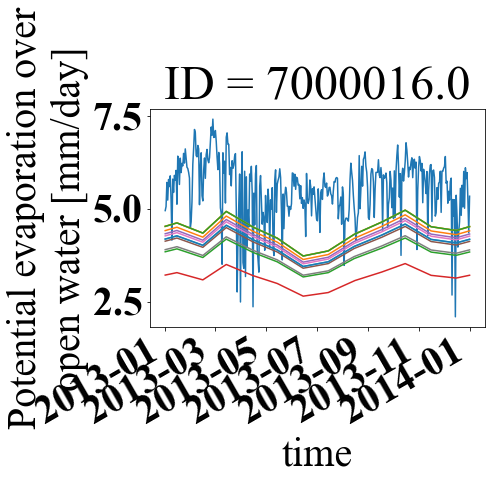

In [104]:
for i in ['','_1','_2','_3','_4','_5','_6','_7','_8','_9','_10','_11','_12']:
    dataset['evapw'+i][:,512].plot()

In [105]:
dataset

<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) float32 ...
    evapw_13   (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:35:57 2023
    Source:       Case: VIC_lake_victoria; remapped by script from library of...